In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
x=np.linspace(0,50,501)
y=np.sin(x)

In [3]:
df=pd.DataFrame(index=x,data=y)

In [4]:
df.columns=['sine']

<Axes: >

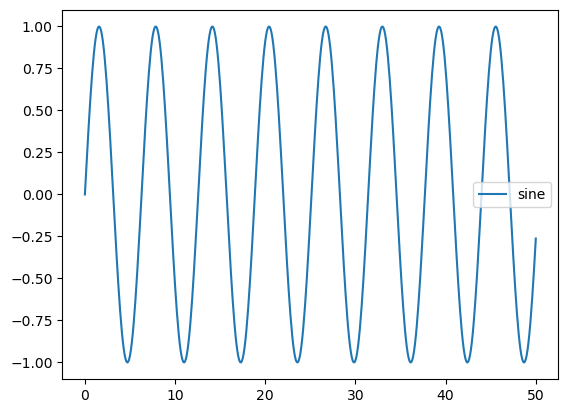

In [5]:
df.plot()

In [6]:
df

,sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
49.6,-0.617439
49.7,-0.535823
49.8,-0.448854
49.9,-0.357400


In [7]:
tes=len(df)-25
train=df.iloc[:tes]
test=df.iloc[tes:]

In [8]:
train

,sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418
...,...
47.1,0.023888
47.2,-0.076037
47.3,-0.175201
47.4,-0.272615


In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler=MinMaxScaler()

In [11]:
scaled_train=scaler.fit_transform(train)
scaled_test=scaler.transform(test)

In [12]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [13]:
length=24
batch_size=1

In [14]:
generator=TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=batch_size)
valid_generator=TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=batch_size)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SimpleRNN

In [16]:
model=Sequential()
model.add(LSTM(50,input_shape=[length,batch_size]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [17]:
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [19]:
model.fit(generator,validation_data=[valid_generator],epochs=20,callbacks=[early_stop])

Epoch 1/20


2023-04-14 10:32:25.248060: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


452/452 [==============================] - 4s 7ms/step - loss: 0.0229 - val_loss: 2.3075e-04
Epoch 2/20
452/452 [==============================] - 3s 7ms/step - loss: 1.0952e-04 - val_loss: 6.2493e-05
Epoch 3/20
452/452 [==============================] - 3s 7ms/step - loss: 1.3237e-04 - val_loss: 7.2108e-05
Epoch 4/20
452/452 [==============================] - 3s 7ms/step - loss: 1.7866e-04 - val_loss: 1.7195e-05
Epoch 5/20
452/452 [==============================] - 3s 7ms/step - loss: 1.5938e-04 - val_loss: 2.5343e-04
Epoch 6/20
452/452 [==============================] - 3s 7ms/step - loss: 1.2489e-04 - val_loss: 3.5319e-04


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [21]:
loss=pd.DataFrame(model.history.history)

In [22]:


test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, 1))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 11ms/step


/var/folders/cn/r_mvyq893c357lflld6x0pvw0000gn/T/ipykernel_95942/2075574314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['LSTM Predictions'] = true_predictions


<Axes: >

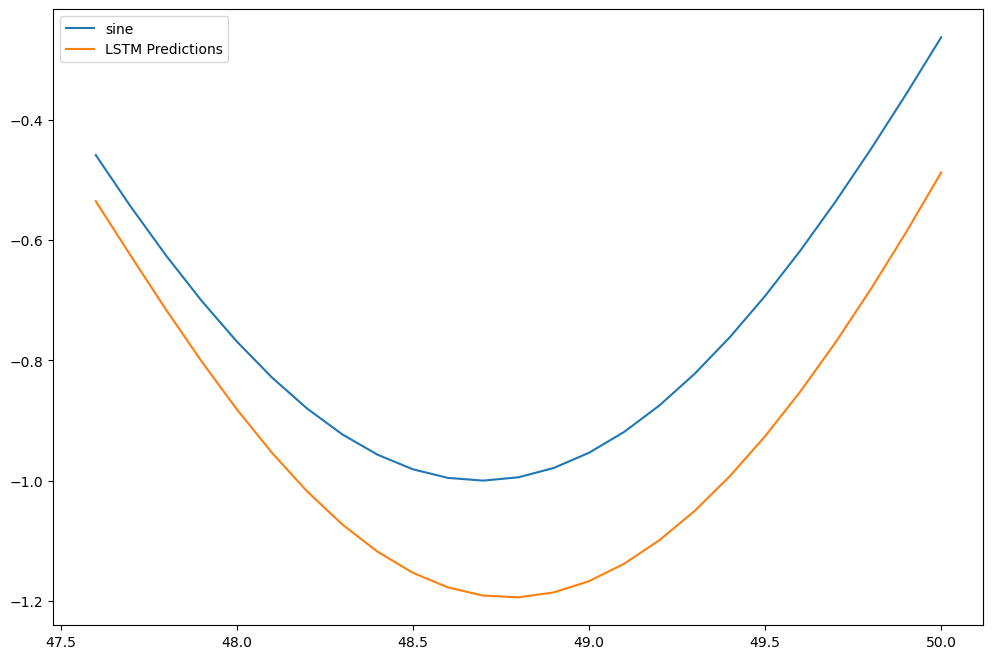

In [23]:
true_predictions = scaler.inverse_transform(test_predictions)
test['LSTM Predictions'] = true_predictions
test.plot(figsize=(12,8))

In [24]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [26]:
model = Sequential()
model.add(LSTM(50, input_shape=(length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=6)

Epoch 1/6


/var/folders/cn/r_mvyq893c357lflld6x0pvw0000gn/T/ipykernel_95942/254570322.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=6)


452/452 [==============================] - 3s 7ms/step - loss: 0.0098
Epoch 2/6
452/452 [==============================] - 3s 7ms/step - loss: 2.0540e-04
Epoch 3/6
452/452 [==============================] - 3s 7ms/step - loss: 2.5771e-04
Epoch 4/6
452/452 [==============================] - 3s 7ms/step - loss: 2.8307e-04
Epoch 5/6
452/452 [==============================] - 3s 7ms/step - loss: 4.7538e-05
Epoch 6/6
452/452 [==============================] - 3s 7ms/step - loss: 1.3632e-04


In [27]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, 1))

for i in range(24):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 18ms/step


In [28]:
forecast = scaler.inverse_transform(forecast)

In [32]:
forecast_index=np.arange(50.1,52.5,step=0.1)

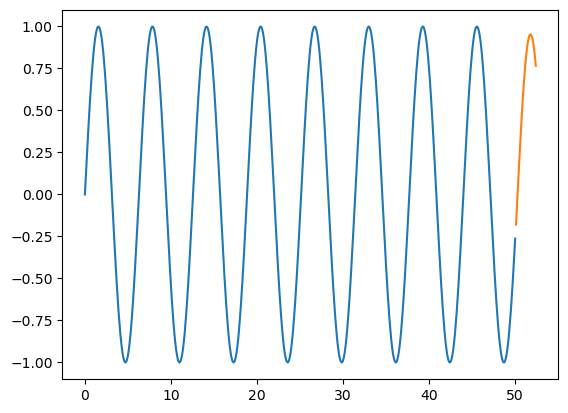

In [33]:
plt.plot(df.index,df['sine'])
plt.plot(forecast_index,forecast)